<a href="https://colab.research.google.com/github/hariharan2302/RL-Project/blob/main/roopeshv_edhanich_hvenkatr_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import torch, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import roopeshv_edhanich_hvenkatr_Environment_Sim as envi

In [ ]:
import matplotlib.pyplot as plt
def Print_graph_1(CRE,msg):
    plt.figure()
    plt.plot(CRE)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Total Reward', fontsize=20)
    plt.title('Total Reward Per Episode '+ msg, fontsize=24)
    plt.grid()
    plt.show()

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(state_dim, 256)
        self.affine2 = nn.Linear(256, 128)
        self.action_head = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        action_probs = F.softmax(self.action_head(x), dim=-1)
        return action_probs

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.affine1 = nn.Linear(state_dim, 256)
        self.affine2 = nn.Linear(256, 128)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        state_value = self.value_head(x)
        return state_value


In [ ]:
class A2C:
    def __init__(self, env, gamma, lr, eps,observation_space,action_space,thresh):
        self.env = env
        self.gamma = gamma
        self.eps = eps
        self.reward_threshold = thresh
        self.state_dim = observation_space
        self.action_dim = action_space
        self.actor = Actor(self.state_dim, self.action_dim)
        self.critic = Critic(self.state_dim)
        self.saved_log_probs = []
        self.rewards = []
        self.values = []
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr)
        self.total_rewards = np.empty((0,))

    def update(self):
        rewards = torch.tensor(self.rewards, dtype=torch.float)
        rewards_dis = torch.flip(torch.cumsum(torch.flip(rewards, [0]), dim=0) * self.gamma, [0])

        saved_log_probs = torch.stack(self.saved_log_probs)
        values = torch.stack(self.values).squeeze(1)
        advantages = rewards_dis - values

        actor_loss = (-saved_log_probs * advantages).mean()
        critic_loss = F.smooth_l1_loss(values, rewards_dis.unsqueeze(1))

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        total_loss = actor_loss + critic_loss
        total_loss.backward()

        self.actor_optimizer.step()
        self.critic_optimizer.step()

        self.saved_log_probs = []
        self.rewards = []
        self.values = []

    def select_action(self, state):
        state = state.float().unsqueeze(0)
        action_probs = self.actor(state)
        state_value = self.critic(state)
        tensor_length = action_probs.size(1)
        action = torch.randint(0, tensor_length, (1,))
        self.saved_log_probs.append(torch.log(action_probs.squeeze(0))[action])
        self.values.append(state_value)
        return action

    def train(self):
        for i_episode in range(1, self.eps+1):
            state, _ = self.env.reset()
            ep_reward = 0
            done = False
            while not done:
                action = self.select_action(state)
                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.rewards.append(reward)
                if (reward==500):
                    print(reward)
                ep_reward += reward
                if done:
                    break
            print("-----------------------------------> n_episode : "+str(i_episode)+"   "+str(ep_reward))
            self.total_rewards = np.append(self.total_rewards, ep_reward)
            self.update()
            torch.save(self.actor, "a2c.pth")
            # if np.mean(self.total_rewards[-30:]) > self.reward_threshold:
            #     break

tensor([ 1.,  7.,  0.,  0., 10.,  5.,  3.,  1.,  0.,  0.,  6., 10.,  2.,  3.,
         0.,  0., 10.,  5.,  4.,  1.,  0.,  0.,  1.,  9.,  5.,  0.,  0.,  0.,
         5., 10.])
-----------------------------------> n_episode : 1   -960.2295449895045
-----------------------------------> n_episode : 2   -936.6237847031598
-----------------------------------> n_episode : 3   -591.5548028383577
-----------------------------------> n_episode : 4   -755.1355928390979
-----------------------------------> n_episode : 5   -880.8392214782624
-----------------------------------> n_episode : 6   -907.256540268981
-----------------------------------> n_episode : 7   -964.6139525433388
-----------------------------------> n_episode : 8   -955.5433909273494
-----------------------------------> n_episode : 9   -967.8463548916385
-----------------------------------> n_episode : 10   -962.4215706283285
-----------------------------------> n_episode : 11   -922.7814159336126
--------------------------------

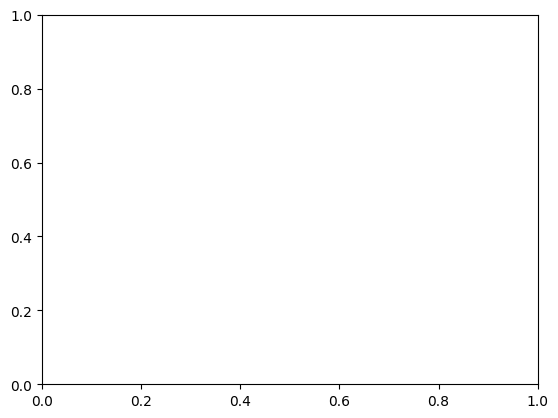

In [ ]:
env = envi.Environment_Sim(4)
state, info = env.reset()
print(state)
n_observations = len(state)
a2c = A2C(env, 0.999, 0.001, 20000,n_observations,9,0)
a2c.train()

In [ ]:
def test(model,env):
    tot_rew = []
    total_reward = 0
    sum_reward = 0
    c = 0
    for i in range(100):
        state, info = env.reset()
        # print(total_reward)
        total_reward = 0
        while True:
            state = state.unsqueeze(0)
            action_probs = model(state)
            _, action = torch.max(action_probs, dim=1)
            observation, reward, terminated, truncated, _ = env.step((action))
            total_reward += reward
            sum_reward += reward
            # env.render()
            state = observation
            if reward == 500:
                c +=1
            if terminated or truncated:
                break
        tot_rew.append(total_reward)
    return tot_rew,c

In [ ]:

temp = test(a2c.actor,env)

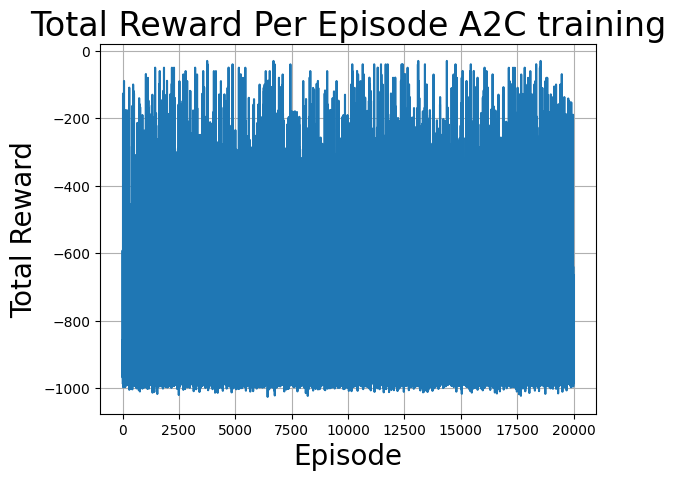

In [ ]:
Print_graph_1(a2c.total_rewards,"A2C training")

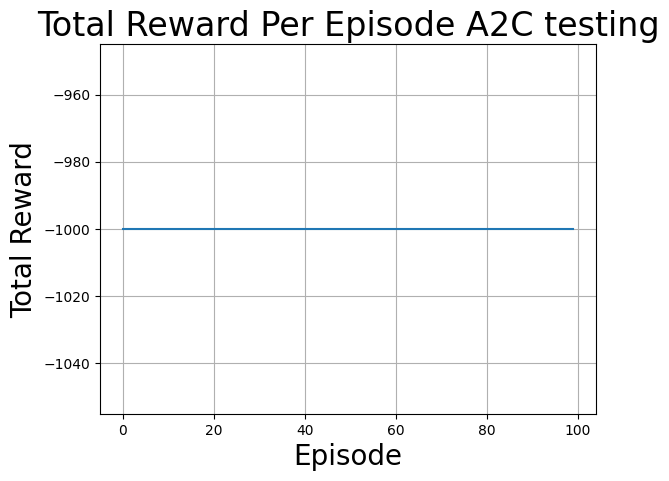

In [ ]:
Print_graph_1(temp[0],"A2C testing")